# Mini-project: Deep Learning from Scratch


---

## Part 1: the classifier and optimizer

### Part 1.1

Some needed imports and seed setting for reproducibility of results

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random
import scipy

from collections import defaultdict
import datetime
from google.colab import files

import pickle

In [54]:
SEED = 1234
np.random.seed(SEED)

### The Softmax function
We will implement softmax the way it was presented in the notes in its vectorized form:
$$P\left( y=p \space | \space X \right) = diag\left\{\sum_{j=1}^{l}exp(X^Tw_j)\right\}^{-1}exp \left( X^Tw_p \right)$$
Using the mentioned workaround to compute extreme exponentials more safely:
$$P\left(y=p \space | \space X \right) = diag\left\{\sum_{j=1}^{l}exp(X^Tw_j - η)\right\}^{-1}exp \left( X^Tw_p - η \right)$$
where:

$X$ is the data matrix with datapoints $x_i$ as it's columns

$w_j$ is the weights vector matching class j

$W$ is the matrix with weights $w_j$ as it's columns

$η$ is a vector containing the max value of each column of $X^Tw_j$




In [55]:
def softmax(X, W, p):
  datapoint_size, datapoints_num = X.shape

  p_weight_multiplied = (X.T @ W[:, p]).reshape(-1,1)
  all_weights_multiplied = X.T @ W

  max = np.max(all_weights_multiplied, axis=1).reshape(-1, 1)
  numerator = np.exp(p_weight_multiplied - max)
  denominator = np.sum(np.exp(all_weights_multiplied - max), axis=1).reshape(-1,1)

#   assert (numerator / denominator).shape == (datapoints_num, 1), f"{(numerator / denominator).shape = }"

  return numerator / denominator

### The Softmax regression loss function

$$F \left( \left\{w_k \right\}_{k=1} ^l \right) = -\frac{1} {m} \sum_{p=1}^l (c_p)^T log\left(diag\left\{\sum_{j=1}^lexp(X^Tw_j)\right\}^{-1} exp(X^Tw_p)\right)$$

In [56]:
def softmax_regression_loss(X, W, C):
  classes_count, datapoints_num = C.shape
  datapoint_size, datapoints_num = X.shape

  log_likelihoods_list = [
    cp_t @ np.log( softmax(X, W, p).squeeze() )
    for p, cp_t in enumerate(C)
  ]

  loss = -1/datapoints_num * np.sum( log_likelihoods_list )

  return loss

### The Softmax regression gradient

$$\nabla_{w_p}F = \frac {1}{m} X \left[diag\left\{\sum_{j}exp(X^T w_j)\right\}^{-1}exp(X^T w_p) -c_p\right]$$

In [57]:
def softmax_regression_gradient_wp(X, W, C, p):
  datapoint_size, datapoints_num = X.shape

  softmax_result = softmax(X, W, p)
  Cp = C.T[:, p].reshape(-1,1)

  grad_wp = 1/datapoints_num * X @ (
      softmax(X, W, p)
      - Cp
  )

#   assert grad_wp.shape == (datapoint_size, 1), f"{grad_wp.shape = }"

  return grad_wp


def softmax_regression_gradient(X, W, C):
  classes_num, datapoints_num = C.shape
  datapoint_size, datapoints_num = X.shape

  grad_wp_list = [
      softmax_regression_gradient_wp(X, W, C, p)
      for p in range(classes_num)
  ]

  grad_W = np.array(grad_wp_list).T.squeeze()

#   assert grad_W.shape == (datapoint_size, classes_num), f"{grad_W.shape = }"

  return grad_W

### Testing Softmax gradient
Definition as seen in lecture:

Let d be a random vector, shuch that $\|d\|=O(1)$ we know that
$$f(x+ϵd)= f(x)+ϵd^T \nabla f +O(ϵ^2)$$

Suppose we have the code $grad(x)$ for computing $\nabla f(x)$. Then we can compare

$$|f(x+ϵd) - f(x)| = O(ϵ)$$

Versus

$$ |f(x+ ϵd) - f(x) - ϵd^Tgrad(x)| = O(ϵ^2)$$



In [58]:
def add_ones_row(X):
  datapoint_size, datapoints_num = X.shape

  X_with_ones = np.vstack([
      X,
      np.ones((1, datapoints_num))
  ])

  return X_with_ones


def gradient_test_random_data(datapoint_size=4, datapoints_num=1000, classes_num=3):
  X_shape = (datapoint_size, datapoints_num)
  X = np.random.uniform(-10, 10, size=X_shape)
  X = add_ones_row(X)

  W_shape = (datapoint_size + 1, classes_num)
  W = np.random.randn(*W_shape)

  C_shape = (classes_num, datapoints_num)
  labels = np.random.randint(classes_num, size=datapoints_num)
  C = np.identity(classes_num)[:, labels] # pulling columns from identity to get one-hot encoding

#   assert C.shape == C_shape, f"{C.shape = }, {C_shape = }"

  return X, W, C

In [59]:
def show_with_legend(title="", x_label="", y_label=""):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


def do_softmax_gradient_test(X, W, C):
  step_direction = np.random.randn(*W.shape)
  epsilon = 0.1

  W0 = W
  objective_at_W0 = softmax_regression_loss(X, W0, C)
  grad_at_W0 = softmax_regression_gradient(X, W0, C)

  steps_num = 8
  errors_order_1 = np.zeros(steps_num)
  errors_order_2 = np.zeros(steps_num)

  steps_axis = np.arange(steps_num)

  # table title
  row_format = "{:<10}{:<30}{:<30}"
  print(
    row_format
    .format("step", "error order 1", "error order 2")
  )

  for step_num in steps_axis:
    step_size = epsilon * (0.5 ** step_num)
    objective_at_Wk = softmax_regression_loss(X, W0 + step_size * step_direction, C)

    errors_order_1[step_num] = np.abs( objective_at_Wk - objective_at_W0 )
    errors_order_2[step_num] = np.abs( objective_at_Wk - objective_at_W0
                                      - step_size * np.sum(
                                          np.multiply(grad_at_W0, step_direction) # element-wise
                                        ) )
    print(
      row_format
      .format(step_num, errors_order_1[step_num], errors_order_2[step_num])
    )
  print()

  plt.semilogy(steps_axis, errors_order_1, label="Zero order approximation") # plot with y axis in log-scaling
  plt.semilogy(steps_axis, errors_order_2, label="First order approximation") # plot with y axis in log-scaling
  show_with_legend(title="Softmax regression gradient test in semilogarithmic plot",
                   x_label="steps", y_label="error")

step      error order 1                 error order 2                 
0         0.24604141968013415           0.05439399680163581           
1         0.1366257029390514            0.013592005301833576          
2         0.07168082243735974           0.003428031683082755          
3         0.03669041557493635           0.0008640114852848935         
4         0.01856016531385052           0.0002170482162601045         
5         0.009334206065675588          5.440069937972386e-05         
6         0.0046806854772398765         1.3617905287779258e-05        
7         0.0023437449769048158         3.406714359012117e-06         



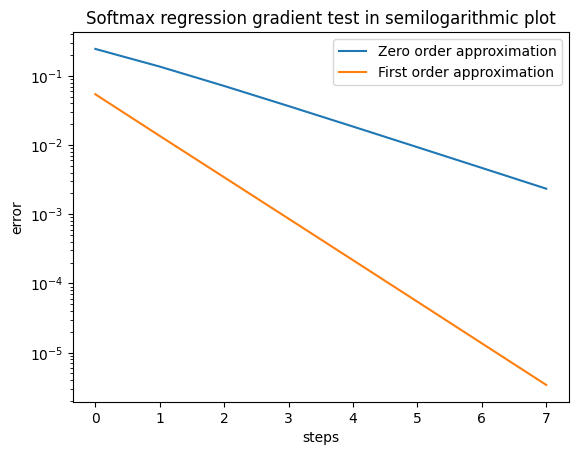

In [60]:
random_data = gradient_test_random_data()
do_softmax_gradient_test(*random_data)

From the difference in slopes we conclude that test is successful and the gradient implementation is correct for the loss function.

---
---
### Part 1.2

### SGD optimizer

Helper functions for the implementation

In [84]:
def epoch_generator(X, Y, minibatch_size):
  datapoint_size, datapoints_num = X.shape

  shuffled_indices = np.random.permutation(datapoints_num)
  minibatch_start = 0
  minibatch_end = min(minibatch_start + minibatch_size, datapoints_num)

  while minibatch_end != datapoints_num:
    minibatch_X = X[ : , shuffled_indices[minibatch_start : minibatch_end]]
    minibatch_Y = Y[ : , shuffled_indices[minibatch_start : minibatch_end]]
    yield minibatch_X, minibatch_Y

    minibatch_start += minibatch_size
    minibatch_end = min(minibatch_start + minibatch_size, datapoints_num)


def randomly_split_dataset(X, Y, split_percentage):
  datapoint_size, datapoints_num = X.shape
  classes_num, datapoints_num = Y.shape

  part_1_size = np.int64(split_percentage * datapoints_num)

  shuffled_indices = np.random.permutation(datapoints_num)
  part_1_indices = shuffled_indices[ : part_1_size]
  part_2_indices = shuffled_indices[part_1_size : ]

  X_1 = X[ : , part_1_indices]
  Y_1 = Y[ : , part_1_indices]

  X_2 = X[ : , part_2_indices]
  Y_2 = Y[ : , part_2_indices]

  return X_1, Y_1, X_2, Y_2


def classification_success(X, weights, Y):
  datapoint_size, datapoints_num = X.shape
  classes_num, datapoints_num = Y.shape

  raw_softmaxes = np.array([
    softmax(X, weights, p)
    for p in range(classes_num)
  ]).squeeze()

  classifications = np.argmax(raw_softmaxes, axis=0)
  true_classes = np.argmax(Y, axis=0)

  return np.sum(classifications == true_classes) / datapoints_num

We chose to implement the ADAM SGD variant.

In [82]:
def ADAM_updated_variables(g, w, m, v, alpha, t):
  epsilon, beta_1, beta_2 = 1e-8, 0.9, 0.999

  # g is given

  m = beta_1*m + (1-beta_1)*g
  m_hat = 1/(1-np.power(beta_1,t)) * m

  v = beta_2*v + (1-beta_2)*(np.power(g,2))
  v_hat = 1/(1-np.power(beta_2,t)) * v

  w -= alpha * m_hat/np.sqrt(v_hat + epsilon)

  return w, m, v


def SGD(X_train, Y_train, X_val, Y_val, objective_func, objective_func_gradient,
        max_epochs=1_000, minibatch_size=50, learning_rate=1e-3,
        classification=False):
  datapoint_size, datapoints_num = X_train.shape
  classes_num, datapoints_num = Y_train.shape

  # subsample size for measuring success
  subsample_size = 0.2 # 20 percent
  X_train_sub, Y_train_sub, _, _ = randomly_split_dataset(X_train, Y_train, split_percentage=subsample_size)
  X_val_sub, Y_val_sub, _, _ = randomly_split_dataset(X_val, Y_val, split_percentage=subsample_size)

  # figuring out weights' dimensions from data
  weights_shape = datapoint_size, classes_num
  weights = np.random.randn( *weights_shape )
  # weights = np.zeros( weights_shape )

  # ADAM initial arguments
  m, v = np.zeros(weights_shape), np.zeros(weights_shape)

  weights_list = [ weights ]
  train_losses_list = [ objective_func(X_train_sub, weights, Y_train_sub) ]
  val_losses_list = [ objective_func(X_val_sub, weights, Y_val_sub) ]

  if classification:
    train_success_percentages = [
        classification_success(X_train_sub, weights, Y_train_sub) ]
    val_success_percentages = [
      classification_success(X_val_sub, weights, Y_val_sub) ]

  # optimization loop
  iteration_num = 0
  for epoch_num in range(1, max_epochs + 1):
    epoch_gradient_norms = []
    for (minibatch_X, minibatch_Y) in epoch_generator(X_train, Y_train, minibatch_size):
      gradient = objective_func_gradient(minibatch_X, weights, minibatch_Y)
      
	  # weights -= learning_rate * gradient
      iteration_num += 1
      weights, m, v = ADAM_updated_variables(gradient, weights, m, v,
        learning_rate, iteration_num)

    # subsample for measuring success
    X_train_sub, Y_train_sub, _, _ = randomly_split_dataset(X_train, Y_train, split_percentage=subsample_size)
    X_val_sub, Y_val_sub, _, _ = randomly_split_dataset(X_val, Y_val, split_percentage=subsample_size)

    train_loss = objective_func(X_train_sub, weights, Y_train_sub)
    validation_loss = objective_func(X_val_sub, weights, Y_val_sub)
    if classification:
      train_success_per = classification_success(X_train_sub, weights, Y_train_sub)
      val_success_per = classification_success(X_val_sub, weights, Y_val_sub)

    weights_list.append(weights)
    train_losses_list.append(train_loss)
    val_losses_list.append(validation_loss)
    if classification:
      train_success_percentages.append(train_success_per)
      val_success_percentages.append(val_success_per)

  if classification:
    return weights_list, train_losses_list, val_losses_list, train_success_percentages, val_success_percentages

  return weights_list, train_losses_list, val_losses_list

Helper function to plot results of the training process

In [83]:
def plot_training_results(weights_list, train_losses_list, validation_losses_list, \
  train_success_percentages=None, validation_success_percentages=None, title=""):

  if train_success_percentages is None:
    plt.plot(train_losses_list, label="Train set")
    plt.plot(validation_losses_list, label="Validation set")
    plt.title(f"{title} loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

  else:
    fig, axis = plt.subplots(1, 2)
    train_success_array = np.array(train_success_percentages) * 100
    validation_success_array = np.array(validation_success_percentages) * 100

    axis[0].plot(train_losses_list, label="Train set")
    axis[0].plot(validation_losses_list, label="Validation set")
    axis[0].set_title(f"loss")
    axis[0].set_xlabel("epoch")
    axis[0].set_ylabel("loss")
    axis[0].legend()

    axis[1].plot(train_success_array, label="Train set")
    axis[1].plot(validation_success_array, label="Validation set")
    axis[1].set_title(f"classification success")
    axis[1].set_xlabel("epoch")
    axis[1].set_ylabel("success %")
    axis[1].legend()
    fig.suptitle(title)
    fig.set_figwidth(16)
    fig.set_figheight(4)
    fig.tight_layout()
    plt.show()


def draw_line(slope, intercept, label, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, label=label, color=color)

### Testing optimizer implementation using random least squares data

Defining the least squares loss:
$$F(w) = \frac{1}{2m} \left\|Xw-y\right\|^2_2$$
And the least squares gradient:
$$\frac{1}{m}\nabla F(x) = 2X^TXw − 2X^Ty$$

In [64]:
def LS_gradient(X, weights, Y):
  datapoint_size, datapoints_num = X.shape

  A = X.T
  b = Y.T

  return (1/datapoints_num * A.T) @ (A @ weights - b)


def LS_loss(X, weights, Y):
  datapoint_size, datapoints_num = X.shape

  A = X.T
  b = Y.T

  diff = A @ weights - b

  loss = 1/(2*datapoints_num) * (diff.T @ diff).squeeze()

  return loss

Randomizing data for a least squares problem

In [65]:
def LS_random_data():
  DATAPOINTS_NUM = 600
  TRUE_WEIGHTS = np.array([3.456, 10.987]).reshape(-1,1)

  X = np.random.uniform(low=-10, high=10, size=(1,DATAPOINTS_NUM))
  X_with_ones = add_ones_row(X)

  y_clean = TRUE_WEIGHTS.T @ X_with_ones
  gausian_noise = np.random.normal( loc=0.0, scale=5, size=y_clean.shape )
  y_noisy = y_clean + gausian_noise

  return X_with_ones, y_noisy, TRUE_WEIGHTS


In [66]:
X_with_ones, y_noisy, true_weights = LS_random_data()
X_train, Y_train, X_val, Y_val = randomly_split_dataset(X_with_ones, y_noisy,
  split_percentage=0.80)

Running optimizer implementation of the random LS problem

In [67]:
weights_list, train_losses_list, validation_losses_list = SGD(X_train, Y_train,
  X_val, Y_val, LS_loss, LS_gradient, max_epochs=20, minibatch_size=50,
  learning_rate=1e-1)

Plotting results

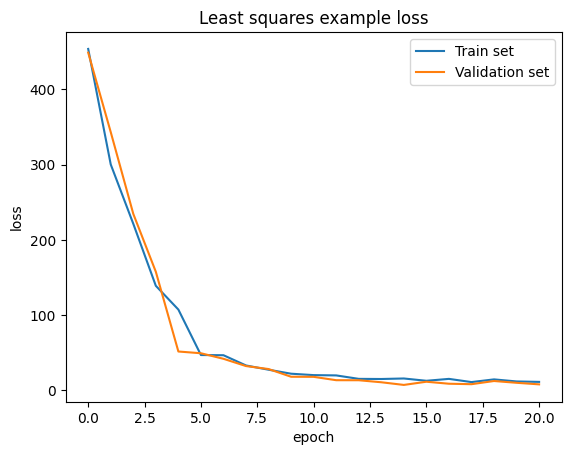

In [68]:
plot_training_results(weights_list, train_losses_list, validation_losses_list,
                      title="Least squares example")

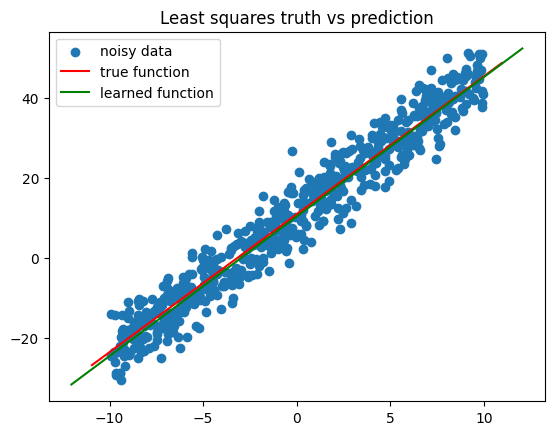

In [92]:
def plot_LS_results(X, true_weights, y_noisy, learned_weights):
  plt.scatter(X, y_noisy, label="noisy data")
  draw_line(*true_weights, label="true function", color="red")
  draw_line(*learned_weights, label="learned function", color="green")
  show_with_legend(title="Least squares truth vs prediction")

  # print()
  # print(f"{np.array(true_weights) = }")
  # print(f"{np.array(learned_weights) = }")

plot_LS_results(X_with_ones[0].flat, true_weights.flat, y_noisy, weights_list[-1].flat)

From the graphs, it's clear that the optimizer successfully found optimization close-enough to the original function despite the noisy data. We conclude that the implementation of the optimizer is valid.

---
---
### Part 1.3

### Demonstrating minimization on the given data
We're given the following data:

Peaks dataset: datapoint size = 2; classes = 2

Peaks dataset: datapoint size = 2; classes = 5

GMM dataset: datapoint size = 3; classes = 5

We'll use it to try to demonstrate the minimization of the softmax function using out SGD variant

Helper functions to load datasets to memory

In [70]:
def load_dataset(path):
  dataset = scipy.io.loadmat(path)

  X_train = np.array(dataset['Yt'])
  Y_train = np.array(dataset['Ct'])

  X_val = np.array(dataset['Yv'])
  Y_val = np.array(dataset['Cv'])

  X_train_with_ones = add_ones_row(X_train)
  X_val_with_ones = add_ones_row(X_train)

  return X_train_with_ones, Y_train, X_val_with_ones, Y_val


def load_swissroll_dataset():
 return load_dataset('SwissRollData.mat')


def load_peaks_dataset():
 return load_dataset('PeaksData.mat')


def load_gmm_dataset():
 return load_dataset('GMMData.mat')

Hyper-parameters:

Testing the training performance, we tried training classification with our optimizer given $learning\_rate∈\left\{1e^-n \space | \space n = 0,1, \dots 5\right\}$ and $minibatch\_size∈\left\{10, 50, 100, 200, 500, 1000\right\}$

In [71]:
minibatch_sizes = [10, 50, 100, 200, 500, 1000]
learning_rates = [10**(-n) for n in range(5+1)]
# minibatch_sizes = [10, 50]
# learning_rates = [10**(-n) for n in range(1)]

datasets = {
    "SwissRoll" : load_swissroll_dataset(),
    "Peaks" : load_peaks_dataset(),
    "GMM" : load_gmm_dataset(),
}

Running the grid search over the parameters for 40 epochs (from what we've seen, this is enough, since after about 20-30 epochs the accuracy on the validation doesn't get better)

In [99]:
grid_search_dict = defaultdict(lambda: defaultdict(dict))
for dataset_name,dataset in datasets.items():
  for minibatch_size in minibatch_sizes:
    for learning_rate in learning_rates:
      grid_search_dict[dataset_name][(learning_rate, minibatch_size)] = SGD(
        *dataset, softmax_regression_loss,
        softmax_regression_gradient, max_epochs=40,
        minibatch_size=minibatch_size, learning_rate=learning_rate,
        classification=True
      )


In [100]:
# saving and downloading the results to avoid running grid search again in case collab session will disconnet
GRID_SEARCH_BACKUP_FILE = f"{datetime.datetime.now():%Y-%m-%d-%H-%M-%S}-ADAM-grid_search_result.bak"

with open(GRID_SEARCH_BACKUP_FILE, "wb") as grid_search_file:
  pickle.dump(dict(grid_search_dict), grid_search_file)

files.download(GRID_SEARCH_BACKUP_FILE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
# code for loading results back if needed
# GRID_SEARCH_BACKUP_FILE = "grid_search_result.bak"
with open(GRID_SEARCH_BACKUP_FILE, "rb") as grid_search_file:
  grid_search_dict = pickle.load(grid_search_file)

The way we determine the best results that we got is by looking at the success percentages on the random subsamples towards the end of the training process (seems like last 30% of epochs is when we should have stability in the results).

How good are the results we received from a combination of the hyperparameters, will be determined by how big is the avg value of the success percentages and how small is the std.

In [115]:
# store the std and avg of val and train accuracy

percent_considered = 0.30
processed_dict = defaultdict(lambda: defaultdict(dict))
for dataset_name in grid_search_dict:
  for (learning_rate, minibatch_size) in grid_search_dict[dataset_name]:
      _, _, _, train_succ_perc, val_succ_perc = grid_search_dict[dataset_name][(learning_rate, minibatch_size)]

      processed_dict[dataset_name][(learning_rate, minibatch_size)] = {
          "v_avg": (np.average(val_succ_perc[int(len(val_succ_perc)*(1-percent_considered)):])*100).round(),
          "v_std": (np.std(val_succ_perc[int(len(val_succ_perc)*(1-percent_considered)):])*100).round(),

          "t_avg": (np.average(train_succ_perc[int(len(val_succ_perc)*(1-percent_considered)):])*100).round(),
          "t_std": (np.std(train_succ_perc[int(len(val_succ_perc)*(1-percent_considered)):])*100).round(),
      }

Displaying the train set's results processing

In [116]:
# on train results
# for each dataset - sort by avg descending, std ascending
print("Train set success % results:")

format_string = "{:<35}{:<20}{:<20}"
for dataset_name in processed_dict:
  print('-'*80)
  print('-'*80)
  print(dataset_name)
  print('-'*80)
  print(
      format_string
      .format("(learning rate, batch size)", "success % avg", "success % std")
  )
  print('-'*80)
  for (learning_rate, minibatch_size),results in sorted(processed_dict[dataset_name].items(), key=lambda item: (-item[1]["t_avg"],item[1]["t_std"])):
    print(
        format_string
        .format(f"{(learning_rate, minibatch_size)}", results["t_avg"], results["t_std"])
    )

Train set success % results:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
SwissRoll
--------------------------------------------------------------------------------
(learning rate, batch size)        success % avg       success % std       
--------------------------------------------------------------------------------
(1e-05, 10)                        57.0                1.0                 
(1e-05, 1000)                      55.0                1.0                 
(0.0001, 50)                       53.0                1.0                 
(1e-05, 200)                       52.0                1.0                 
(0.01, 10)                         52.0                2.0                 
(0.0001, 10)                       52.0                3.0                 
(0.001, 200)                       52.0                3.0                 
(1, 10)                      

Displaying the validation set's results processing

In [117]:
# on validation results
# for each dataset - sort by avg descending, std ascending
print("Validation set success % results:")

format_string = "{:<35}{:<20}{:<20}"
for dataset_name in processed_dict:
  print('-'*80)
  print('-'*80)
  print(dataset_name)
  print('-'*80)
  print(
      format_string
      .format("(learning rate, batch size)", "success % avg", "success % std")
  )
  print('-'*80)
  for (learning_rate, minibatch_size),results in \
      sorted(processed_dict[dataset_name].items(),
          key=lambda item: (-item[1]["v_avg"],item[1]["v_std"])):
    print(
        format_string
        .format(f"{(learning_rate, minibatch_size)}", results["v_avg"], results["v_std"])
    )

Validation set success % results:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
SwissRoll
--------------------------------------------------------------------------------
(learning rate, batch size)        success % avg       success % std       
--------------------------------------------------------------------------------
(0.0001, 50)                       52.0                1.0                 
(1e-05, 50)                        52.0                1.0                 
(0.01, 10)                         51.0                1.0                 
(1e-05, 10)                        51.0                1.0                 
(1e-05, 200)                       51.0                1.0                 
(0.01, 500)                        51.0                1.0                 
(1e-05, 500)                       51.0                1.0                 
(0.0001, 1000)          

Plotting the training info (losses and success %) for the results deemed to be the best we got

For each dataset 4 plots will be produced:
* 2 plots for the training that produced the best results on the validation set
* 2 plots for the training that produced the best results on train set

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
SwissRoll
--------------------------------------------------------------------------------


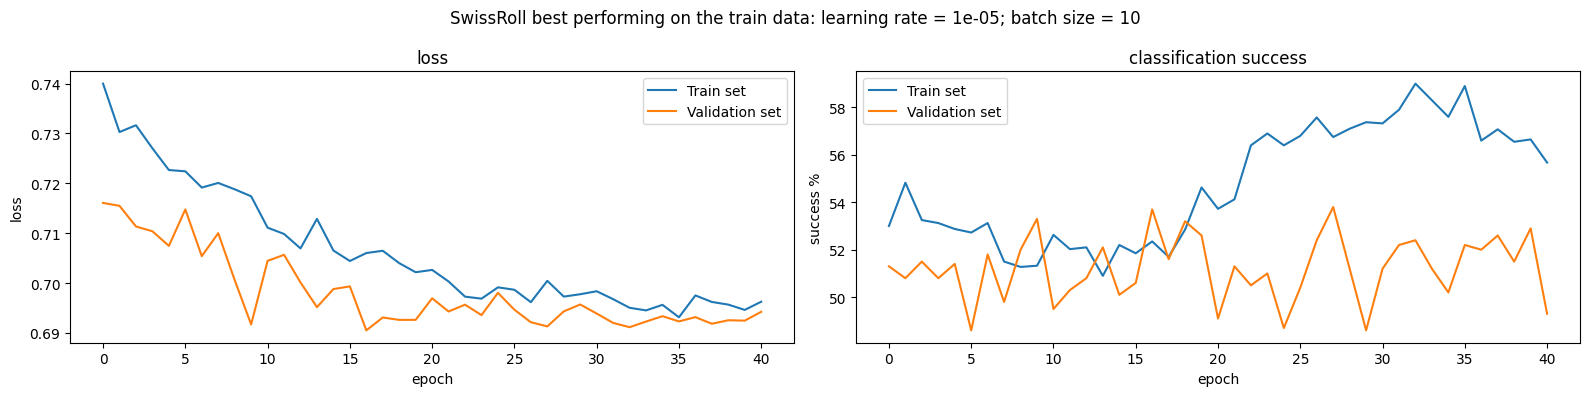

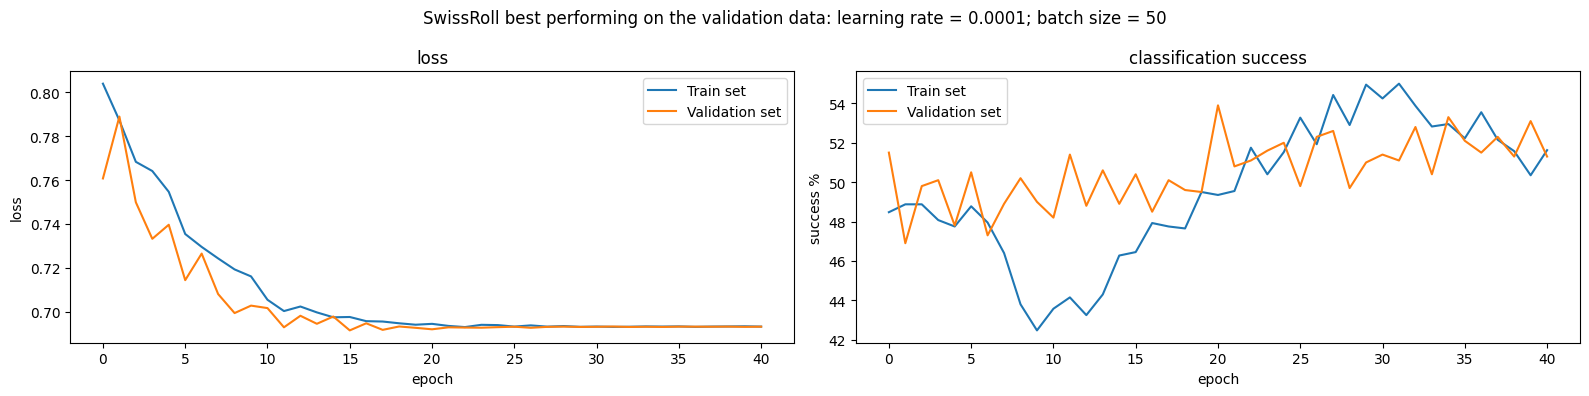

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Peaks
--------------------------------------------------------------------------------


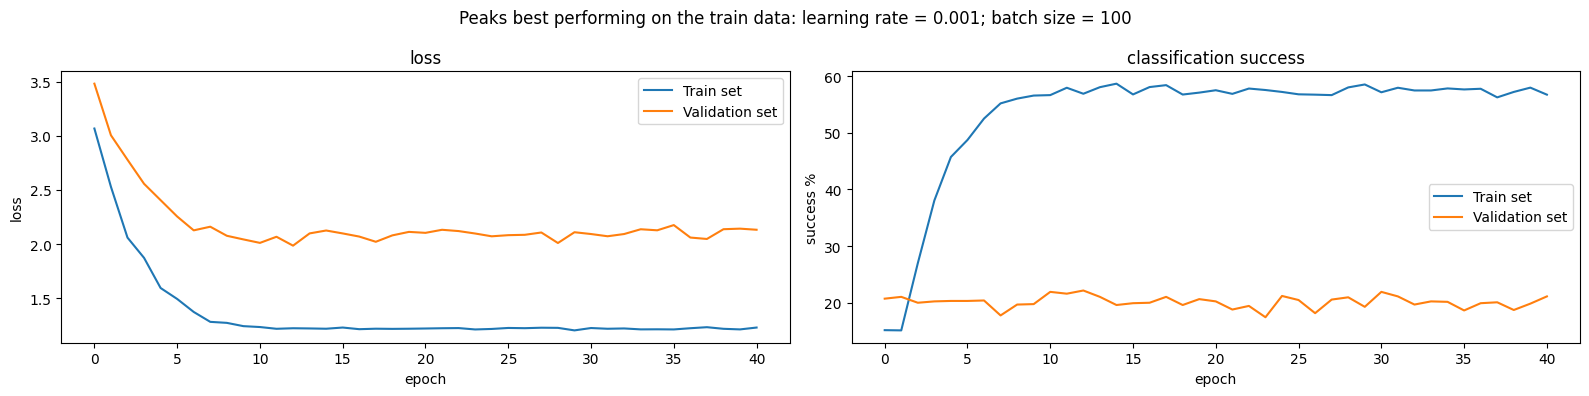

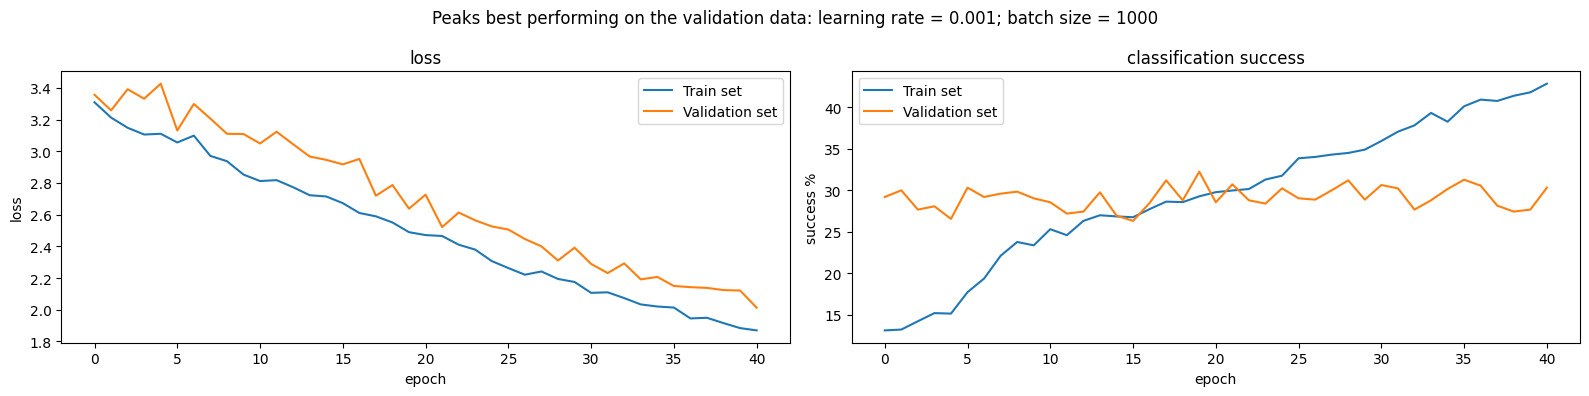

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
GMM
--------------------------------------------------------------------------------


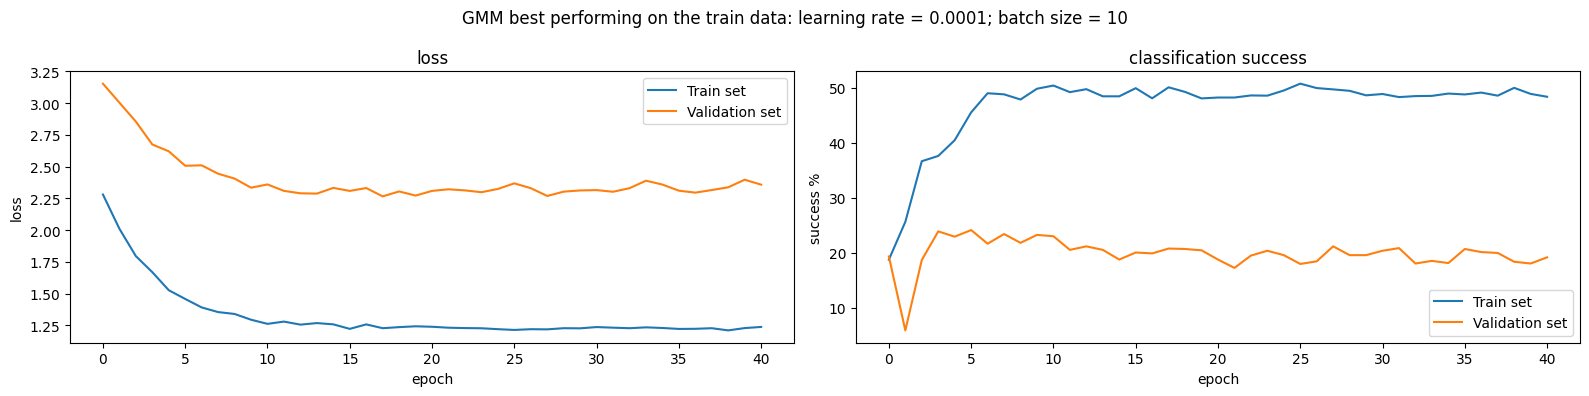

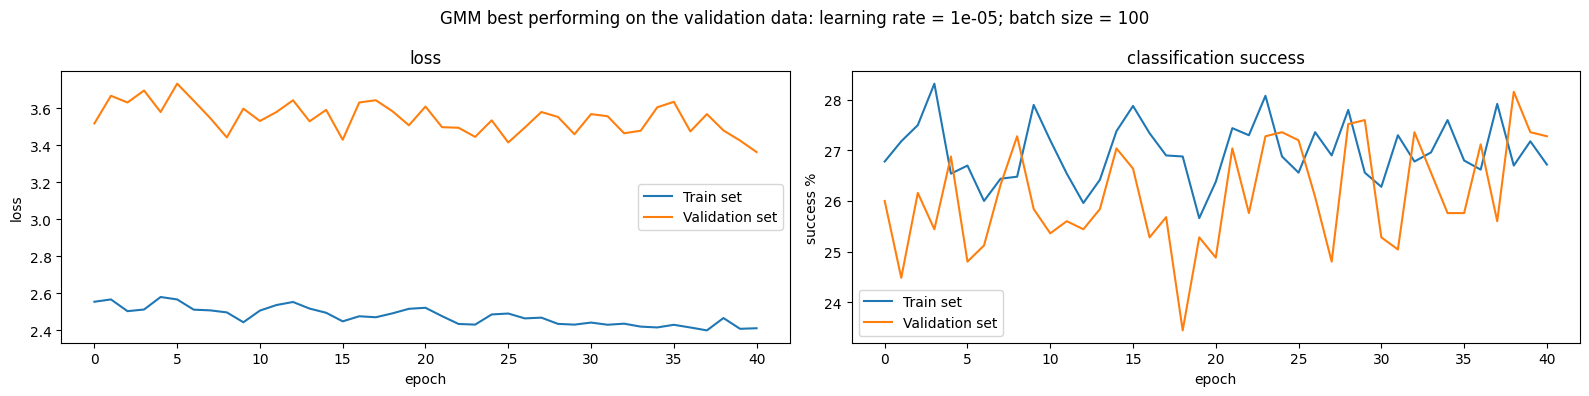

In [118]:
# for each dataset 4 plots will be produced:
  # 2 plots for the training that produced the best results on the validation set
  # and 2 plots for the training that produced the best results on train set

for dataset_name in processed_dict:
  print('-'*80)
  print('-'*80)
  print(dataset_name)
  print('-'*80)


  top_validation = min(processed_dict[dataset_name].items(),
                  key=lambda item: (-item[1]["v_avg"],item[1]["v_std"]))
  top_train = min(processed_dict[dataset_name].items(),
                  key=lambda item: (-item[1]["t_avg"],item[1]["t_std"]))
  top_val_index = top_validation[0]
  top_train_index = top_train[0]

  plot_training_results(*grid_search_dict[dataset_name][top_train_index], title=f"{dataset_name} best performing on the train data: learning rate = {top_train_index[0]}; batch size = {top_train_index[1]}")
  plot_training_results(*grid_search_dict[dataset_name][top_val_index], title=f"{dataset_name} best performing on the validation data: learning rate = {top_val_index[0]}; batch size = {top_val_index[1]}")



## Conclusions

### How well does the model fit to the data

We've demonstrated that our implementation of the softmax regression is valid, using the gradient test.

We demonstrated that our optimizer implementation is valid using the least squares example.

We covered a wide-enough range of possible batch size and learning raate parameters when trying to optimize training for the given datasets.

Since we didn't succeed in getting high accuracy results neither on the train set nor on the validation set on any of the datasets, we conclude that softmax regression is underfit for the data.

### Did the model succeeded in learning anything at all

* For the Swissroll dataset "chance" is 50%.
  
  * Best avg validation set result was around 52% with std of 1% -> (meaningless)
  * Best avg train set result was around 57% with std of 1% -> (+7%)

* For the Peaks dataset "chance" is 20%.
  * Best avg validation set result was around 29% with std of 1% -> (+9%)
  * Best avg train set result was around 58% with std of 1% -> (+38%)

* For the GMM dataset "chance" is 20%
  * Best avg validation set result was around 27% with std of 1% -> (+7%)
  * Best avg train set result was around 49% with std of 0% -> (+29%)

From the results it's clear that the model did succeeded in learning something especially on the train set. But it wasn't generalizing enough.

